In [9]:
from gcm import GCM
import pandas as pd
from scipy.stats import normaltest

from IPython.display import display
import matplotlib.pyplot as plt

from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score, mean_squared_error
import numpy as np

## Step 0: Functions

In [10]:
def scatter(df, columns):
    fig, ax = plt.subplots(1, 1, figsize=(6,6))
    ax.scatter(df[columns[0]], df[columns[1]], alpha=0.5)
    ax.set_xlabel(columns[0])
    ax.set_ylabel(columns[1])
    ax.set_title(f"Scatter plot of {columns[0]} vs {columns[1]}")
    plt.show()

In [11]:
def compute_multipole(df: pd.DataFrame, columns: list, method="pearson"):
    corr_matrix = df[columns].corr(method=method)
    eigenvalues = np.linalg.eigvalsh(corr_matrix)
    multipole = 1 - min(eigenvalues)
    return multipole

In [12]:
def prep_lcd(df):
    numeric_df = df.dropna(axis=1).iloc[:,2:]  # Drop duplicate column.
    
    columns_to_drop = ['policy_code', 'collections_12_mths_ex_med', 'chargeoff_within_12_mths','delinq_amnt', 'tax_liens','pub_rec_bankruptcies']
    numeric_df = numeric_df.drop(columns=columns_to_drop)
    rename_map = {
        # Scenario 1
        'mort_acc': 'number_of_mortgage_accounts', # Number of mortgage accounts.
        'tot_hi_cred_lim': 'total_credit_limit', # Total high credit/credit limit
        'total_bal_ex_mort': 'balance_excl_mortgage', # Total credit balance excluding mortgage
    
        # Scenario 2
        'delinq_2yrs': 'delinquencies_2yrs', # The number of 30+ days past-due incidences of delinquency in the borrower's credit file for the past 2 years
        'int_rate': 'interest_rate', # Interest Rate on the loan
        # total_credit_lim
        
        # Scenario 3
        'annual_inc': 'annual_income' # The self-reported annual income provided by the borrower during registration.
        # interest_rate
        # total_credit_limit
    }
    
    
    numeric_df = numeric_df.rename(columns=rename_map)
    return numeric_df

In [13]:
def prep_heart(df):
    return df
    

In [14]:
def prep_body(df):
    return df

In [15]:
def prep_dataset(dataset):    
    df = pd.read_csv(f"./data/{dataset['path']}",nrows=10000)
    numeric_df = df.select_dtypes(include="number")
    if ds['name'] == 'Loan Club':
        numeric_df = prep_lcd(numeric_df)
    elif ds['name'] == 'Heart Sensors':
        numeric_df = prep_heart(numeric_df)
    elif ds['name'] == 'Body Measurements':
        numeric_df = prep_body(numeric_df)
    else:
        raise ValueError("Unknown dataset")
    
    df_train_prep = numeric_df.iloc[:int(0.9*len(numeric_df))]
    df_test_prep = numeric_df.iloc[int(0.9*len(numeric_df)):]
    print("Number of columns:", numeric_df.shape[1])
    return df_train_prep, df_test_prep

In [16]:
def read_json(dataset):
    import json
    with open(f"./data/dataset_json/{dataset}.json", 'r') as f:
        data = json.load(f)
    return data


# Step 1: Load Data

In [18]:
name = 'LoanClub' # HeartSensors, 'LoanClub', 'BodyMeasurements'
ds = read_json(name)
print(ds['description'])

df_train, df_test = prep_dataset(ds)
df_train.head()

A dataset containing information about loans issued by the Loan Club platform, including borrower details, loan amounts, interest rates, and repayment status.
Number of columns: 54


/tmp/ipykernel_12435/2967164488.py:2: DtypeWarning: Columns (19) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(f"./data/{dataset['path']}",nrows=10000)


,funded_amnt,funded_amnt_inv,interest_rate,installment,annual_income,dti,delinquencies_2yrs,fico_range_low,fico_range_high,inq_last_6mths,...,num_rev_tl_bal_gt_0,num_sats,num_tl_30dpd,num_tl_90g_dpd_24m,num_tl_op_past_12m,pct_tl_nvr_dlq,total_credit_limit,balance_excl_mortgage,total_bc_limit,total_il_high_credit_limit
0,3600.0,3600.0,13.99,123.03,55000.0,5.91,0.0,675.0,679.0,1.0,...,4.0,7.0,0.0,0.0,3.0,76.9,178050.0,7746.0,2400.0,13734.0
1,24700.0,24700.0,11.99,820.28,65000.0,16.06,1.0,715.0,719.0,4.0,...,5.0,22.0,0.0,0.0,2.0,97.4,314017.0,39475.0,79300.0,24667.0
2,20000.0,20000.0,10.78,432.66,63000.0,10.78,0.0,695.0,699.0,0.0,...,3.0,6.0,0.0,0.0,0.0,100.0,218418.0,18696.0,6200.0,14877.0
3,35000.0,35000.0,14.85,829.90,110000.0,17.06,0.0,785.0,789.0,0.0,...,5.0,13.0,0.0,0.0,1.0,100.0,381215.0,52226.0,62500.0,18000.0
4,10400.0,10400.0,22.45,289.91,104433.0,25.37,1.0,695.0,699.0,3.0,...,6.0,12.0,0.0,0.0,4.0,96.6,439570.0,95768.0,20300.0,88097.0


# Step 2: Get Correlation Matrix and Multipoles for Different Scenarios

In [19]:
scenarios = ds['mvc']
scenarios_dict = {i: {'columns': s, 'Original Multipole': None,
                      'Synthetic Multipole': None}
                  for i, s in enumerate(scenarios)}

# pairwise correlations:

for i, s in enumerate(scenarios):
    corr_matrix = df_train[s].corr(method='pearson')
    print(f"Scenario {i + 1}")
    print("Pairwise correlation matrix")
    display(corr_matrix)
    multipole_val = compute_multipole(df_train, s, method='pearson')
    
    scenarios_dict[i]['Original Multipole'] = multipole_val
    print(f"Columns: {s}, Multipole: {multipole_val:.4f}")
    
    
    print("\n")

Scenario 1
Pairwise correlation matrix


,number_of_mortgage_accounts,total_credit_limit,balance_excl_mortgage
number_of_mortgage_accounts,1.000000,0.541028,0.147618
total_credit_limit,0.541028,1.000000,0.505480
balance_excl_mortgage,0.147618,0.505480,1.000000


Columns: ['number_of_mortgage_accounts', 'total_credit_limit', 'balance_excl_mortgage'], Multipole: 0.6705


Scenario 2
Pairwise correlation matrix


,delinquencies_2yrs,interest_rate,number_of_mortgage_accounts
delinquencies_2yrs,1.000000,0.033271,0.056696
interest_rate,0.033271,1.000000,-0.097624
number_of_mortgage_accounts,0.056696,-0.097624,1.000000


Columns: ['delinquencies_2yrs', 'interest_rate', 'number_of_mortgage_accounts'], Multipole: 0.1292


Scenario 3
Pairwise correlation matrix


,total_credit_limit,interest_rate,annual_income
total_credit_limit,1.000000,-0.133282,0.419759
interest_rate,-0.133282,1.000000,-0.093332
annual_income,0.419759,-0.093332,1.000000


Columns: ['total_credit_limit', 'interest_rate', 'annual_income'], Multipole: 0.4218


# Step 3: Fit GCM and Generate Synthetic Data

In [28]:
# Initialize the GCM model and fit it to your source data
gcm = GCM()
gcm.fit(df_train)

# Generate synthetic samples
synthetic_data = pd.DataFrame(gcm.sample(num_samples=1000000), columns=df_train.columns)

print("Shape of Synthetic Data is {} X {}".format(synthetic_data.shape[0], synthetic_data.shape[1]))

synthetic_data.head()

Shape of Synthetic Data is 1000000 X 54


,funded_amnt,funded_amnt_inv,interest_rate,installment,annual_income,dti,delinquencies_2yrs,fico_range_low,fico_range_high,inq_last_6mths,...,num_rev_tl_bal_gt_0,num_sats,num_tl_30dpd,num_tl_90g_dpd_24m,num_tl_op_past_12m,pct_tl_nvr_dlq,total_credit_limit,balance_excl_mortgage,total_bc_limit,total_il_high_credit_limit
0,21531.152930,21540.593199,14.950322,590.412638,32197.243933,33.024851,-0.837798,655.991088,659.991851,1.390518,...,7.010943,5.892828,-0.011425,-0.274180,-1.151439,88.909607,243801.911318,4684.128396,-4113.320880,13535.324211
1,6360.769888,6371.055621,16.565088,275.142549,196863.384777,42.646193,0.458827,678.997674,682.989560,0.014418,...,4.879582,4.748750,0.054453,0.011654,2.093046,98.286039,33063.475522,80306.185738,21244.454311,57206.147890
2,14062.171317,14077.270930,9.989510,558.232293,103505.705345,13.769671,0.940379,662.963855,666.940845,0.396927,...,6.909013,9.520545,0.025030,0.144408,3.460638,87.427044,103833.948939,-37988.790147,15918.168415,-31129.284944
3,9281.856898,9263.346472,18.246052,244.990257,-98544.377866,25.795138,0.770671,705.113859,709.098461,2.701075,...,3.740380,11.555912,0.015301,0.117675,3.291845,92.931411,190951.454213,36486.265766,35743.820181,27492.503844
4,17149.306790,17150.415177,15.579215,521.615180,71780.142785,4.447392,-0.741088,753.202077,757.208948,1.604232,...,-0.598831,6.259102,0.052294,-0.896945,3.916837,99.706573,-104515.288467,18112.837919,7265.807043,22442.495474


# Step 4: Validate Results

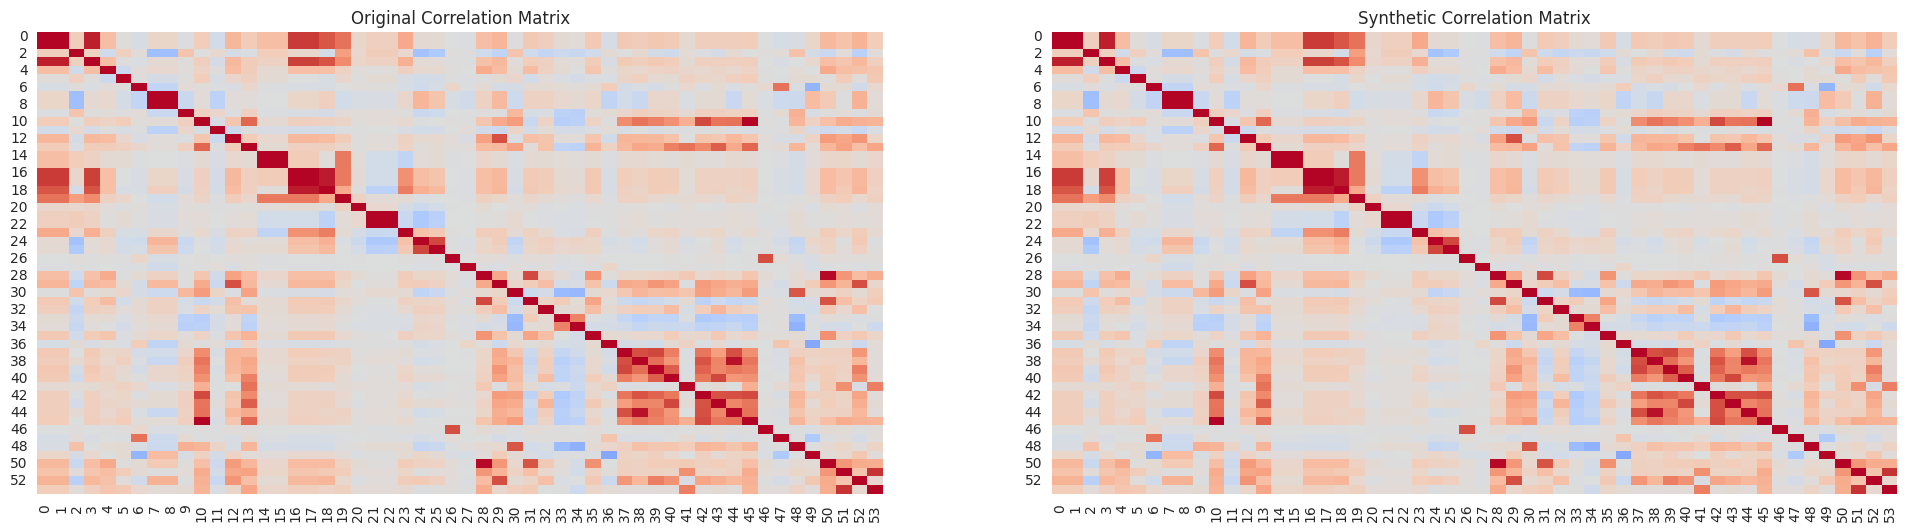

In [23]:
import matplotlib.pyplot as plt
import seaborn as sns


# Verify that the correlation structure is preserved
corr_real = np.corrcoef(df_train, rowvar=False)
corr_synth = np.corrcoef(synthetic_data, rowvar=False)

fig, axes = plt.subplots(1, 2, figsize=(24,6))

sns.heatmap(corr_real, ax=axes[0], cmap="coolwarm", center=0, cbar=False)
axes[0].set_title("Original Correlation Matrix")
sns.heatmap(corr_synth, ax=axes[1], cmap="coolwarm", center=0, cbar=False)
axes[1].set_title("Synthetic Correlation Matrix")
plt.show()


In [24]:
# Are the multipoles preserved?
for i, s in enumerate(scenarios):
    scenarios_dict[i]['Synthetic Multipole'] = compute_multipole(pd.DataFrame(synthetic_data, columns=df_train.columns), s, method="pearson")
    
    
# Convert to DataFrame
results = pd.DataFrame.from_dict(scenarios_dict, orient='index')

# Format numeric columns nicely
numeric_cols = ['Original Multipole', 'Synthetic Multipole']
results[numeric_cols] = results[numeric_cols].applymap(lambda x: f"{x:.4f}" if x is not None else "-")
display(results)


,columns,Original Multipole,Synthetic Multipole
0,"[number_of_mortgage_accounts, total_credit_lim...",0.6705,0.6702
1,"[delinquencies_2yrs, interest_rate, number_of_...",0.1292,0.1289
2,"[total_credit_limit, interest_rate, annual_inc...",0.4218,0.4216


### Higher-order correlations are preserved well in the synthetic data.

# Step 5: Downstream task analysis

In [26]:
# Features and target
features = ds['reg']['features']
target = ds['reg']['target']

X_train = df_train[features]
y_train = df_train[target]

X_synth = synthetic_data[features]
y_synth = synthetic_data[target]

X_test = df_test[features]
y_test = df_test[target]

# Train models
reg_org = LinearRegression().fit(X_train, y_train)
reg_synth = LinearRegression().fit(X_synth, y_synth)


# Evaluate on the same held-out test set
y_pred_org = reg_org.predict(X_test)
y_pred_synth = reg_synth.predict(X_test)


metrics = {
    "R2_org": r2_score(y_test, y_pred_org),
    "MSE_org": mean_squared_error(y_test, y_pred_org),
    "R2_synth": r2_score(y_test, y_pred_synth),
    "MSE_synth": mean_squared_error(y_test, y_pred_synth)
}

print(metrics)

{'R2_org': 0.8746321766113988, 'MSE_org': 18.45988244028554, 'R2_synth': 0.8745741868544392, 'MSE_synth': 18.46842118704911}


# The R2 and MSE values for the models trained on original and synthetic data are similar, indicating that the synthetic data is effective for training predictive linear models.